In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
from ipdb import set_trace as bp
from numba.typed import List

from collections import namedtuple
import torch

np.set_printoptions(linewidth=160, precision=2)

In [77]:
ParamTuple = namedtuple("ParamTuple", ["p", "gamma", "R"])
StateTransition = namedtuple("StateTransition", ["s", "a", "s_next"])

In [3]:
# @jit(nopython=True)
def value_iteration_with_policy(
    R: np.ndarray,
    T_agent: np.ndarray,
    gamma: float,
    tol: float = 1e-6,
):
    n_states = R.shape[0]
    V = np.zeros(n_states)
    policy = np.zeros(n_states, dtype=np.int32)
    while True:
        V_new = np.zeros(n_states)
        for s in range(n_states):
            action_values = R[s] + gamma * np.sum(T_agent[s] * V, axis=1)
            best_action = np.argmax(action_values)
            V_new[s] = action_values[best_action]
            policy[s] = best_action
        if np.max(np.abs(V - V_new)) < tol:
            break
        V = V_new
    V = V / np.max(V) * R.max()
    return V, policy

In [4]:
# @njit
def soft_q_iteration(
    R: np.ndarray,  # R is a one-dimensional array with shape (n_states,)
    T_agent: np.ndarray,
    gamma: float,
    beta: float,  # Inverse temperature parameter for the softmax function
    tol: float = 1e-6,
) -> np.ndarray:
    n_states, n_actions, _ = T_agent.shape
    V = np.zeros(n_states)
    Q = np.zeros((n_states, n_actions))
    policy = np.zeros((n_states, n_actions))

    while True:
        for s in range(n_states):
            for a in range(n_actions):
                # Calculate the Q-value for action a in state s
                Q[s, a] = R[s] + gamma * np.dot(T_agent[s, a], V)

        # Apply softmax to get a probabilistic policy
        max_Q = np.max(Q, axis=1, keepdims=True)
        exp_Q = np.exp(beta * (Q - max_Q))  # Subtract max_Q for numerical stability
        policy = exp_Q / np.sum(exp_Q, axis=1, keepdims=True)

        # Calculate the value function V using the probabilistic policy
        V_new = np.sum(policy * Q, axis=1)
        # V_new = sum_along_axis_1(policy * Q)

        # Check for convergence
        if np.max(np.abs(V - V_new)) < tol:
            break

        V = V_new

    return policy

In [5]:
def generate_trajectory(T_true, policy, absorbing_states, start_state=0, max_steps=100):
    trajectory = []
    current_state = start_state
    n_states, n_actions = policy.shape

    while len(trajectory) < max_steps:
        if current_state in absorbing_states:
            trajectory.append((current_state, -1, -1))  # Append the absorbing state
            break
        # Sample an action based on the policy probabilities for the current state
        action_probabilities = policy[current_state]
        chosen_action = np.random.choice(n_actions, p=action_probabilities)

        # Manually sample next_state based on T_true
        next_state = np.random.choice(n_states, p=T_true[current_state, chosen_action])

        trajectory.append((current_state, chosen_action, next_state))
        current_state = next_state

    return np.array(trajectory)

In [6]:
def generate_n_trajectories(
    T_true, policy, absorbing_states, start_state=0, n_trajectories=100, max_steps=100
):
    trajectories = list()
    for _ in range(n_trajectories):
        trajectories.append(
            generate_trajectory(
                T_true,
                policy,
                absorbing_states,
                start_state=start_state,
                max_steps=max_steps,
            )
        )
    return trajectories

In [7]:
# @jit(nopython=True)
def make_absorbing(absorbing_states, T: np.ndarray) -> None:
    # Now all states with non-zero rewards are absorbing states
    # reward_indices = np.where(absorbing_states != 0)[0]
    T[absorbing_states, :, :] = 0
    T[absorbing_states, :, absorbing_states] = 1

In [8]:
def transition_matrix(N, M, p, absorbing_states):
    n_states = N * M
    n_actions = 4  # N, E, S, W

    # Initialize the transition matrix T(s, a, s')
    T = np.zeros((n_states, n_actions, n_states))

    # Helper function to convert 2D grid indices to 1D state index
    to_s = lambda i, j: i * M + j

    # Populate the transition matrix
    for i in range(N):
        for j in range(M):
            s = to_s(i, j)

            # Neighboring states
            neighbors = {
                "N": to_s(i - 1, j) if i > 0 else s,
                "E": to_s(i, j + 1) if j < M - 1 else s,
                "S": to_s(i + 1, j) if i < N - 1 else s,
                "W": to_s(i, j - 1) if j > 0 else s,
            }

            # Set transition probabilities
            for a, action in enumerate(["N", "E", "S", "W"]):
                T[s, a, neighbors[action]] = p
                for other_action in set(["N", "E", "S", "W"]) - {action}:
                    T[s, a, neighbors[other_action]] += (1 - p) / 3

    # Make the transition matrix absorbing

    make_absorbing(absorbing_states, T)

    return T

In [9]:
def plot_trajectories(N, M, trajectories, reward_matrix, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(M, N))

    # Plot rewards as heatmap
    im = ax.imshow(
        reward_matrix.reshape(N, M), cmap="viridis", origin="upper", vmin=-10
    )

    # Plot trajectories
    for traj in trajectories:
        x_coords, y_coords = [], []
        for s, _, _ in traj:
            x, y = divmod(s, M)
            x_coords.append(x)
            y_coords.append(y)

        # Plot the trajectories with a color that stands out
        ax.plot(y_coords, x_coords, marker="o", color="white", alpha=0.5)

    # Assuming 'ax' is the Axes object and 'im' is the image or collection you want the colorbar for:
    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.set_label("Reward")

    # Restrict the colorbar values

    # To move the x-axis ticks to the top using the Axes object:
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")  # To also move the x-axis label if you have one

In [10]:
# Make function to calculate log-likelihood of a trajectory given a transition matrix and policy
# @njit
def compute_log_likelihood(T, policy, trajectory):
    log_likelihood = 0.0
    for s, a, next_s in trajectory[:-1]:
        log_likelihood += np.log(T[s, a, next_s] * policy[s, a])
    return log_likelihood


def log_likelihood_torch(T, policy, trajectory):
    log_likelihood = torch.tensor(0.0)
    for s, a, next_s in trajectory[:-1]:
        log_likelihood += torch.log(T[s, a, next_s] * policy[s, a])
    return log_likelihood

## Experiment with inserting walls


In [11]:
def insert_walls_into_transition_matrix(T, n_walls, absorbing_states, start_state=0):
    """
    Randomly inserts wall blocks into the transition matrix T.

    :param T: The transition matrix with shape (n_states, n_actions, n_states).
    :param n_walls: The number of walls (cells with zero transition probability) to insert.
    :return: The modified transition matrix with walls inserted.
    """
    n_states, n_actions, _ = T.shape
    T = T.copy()

    # Enumerate all states that can have a wall (i.e. states with reward = 0 and not the start state)
    # wall_candidates = np.where((absorbing_states) & (np.arange(n_states) != start_state))[0] #paul: changed R <= 0 to R == 0 to not insert 
    #rewards in states with negative reward
    wall_candidates = np.delete(np.arange(n_states), absorbing_states)
    wall_candidates = np.delete(wall_candidates, start_state)

    # Ensure we're not inserting more walls than there are states.
    n_walls = min(n_walls, len(wall_candidates))

    # Randomly select states to turn into walls.
    wall_states = np.random.choice(wall_candidates, size=n_walls, replace=False)

    # Set the transition probabilities into the wall states to zero.
    for s in wall_states:
        for a in range(n_actions):
            # Zero out all transitions leading into the wall state.
            T[:, a, s] = 0

            # Zero out all transitions leading out of the wall state.
            T[s, a, :] = 0

    # After modifying the transition probabilities, we need to re-normalize the transition
    # probabilities for each state and action to ensure they still sum to 1.
    for s in range(n_states):
        for a in range(n_actions):
            prob_sum = T[s, a].sum()
            if prob_sum > 0:
                T[s, a] /= prob_sum

    return T, wall_states

In [12]:
from matplotlib.patches import Rectangle


def plot_environment(reward_function, wall_states, start_state=(0, 0), ax=None):
    # Assume the reward function is already reshaped to a 2D grid
    N, M = reward_function.shape
    # Identify wall states is the indixes into the

    wall_states = set([(s // M, s % M) for s in wall_states])

    if ax is None:
        fig, ax = plt.subplots()

    ax.matshow(reward_function, cmap=plt.cm.Wistia)

    # Annotate each cell with the reward, start, and wall
    for (i, j), val in np.ndenumerate(reward_function):
        if (i, j) == start_state:
            ax.text(j, i, "Start", va="center", ha="center")
        elif (i, j) in wall_states:
            # Add a dark gray rectangle to represent the wall
            ax.add_patch(Rectangle((j - 0.5, i - 0.5), 1, 1, color="darkgray"))
        else:
            ax.text(j, i, f"{val:.2f}", va="center", ha="center")

## Put it all together into one big function

The procedure is as follows:

1. Initialize variables for storing the highest Bayesian regret and the corresponding environment $T$.
1. Sample $n$ samples of the parameters $\theta=(\gamma_i, p_i)$ from the posterior $p(\theta|\mathcal D)$ (But we start with a uniform prior).
1. Create $t = |T|$ randomly generated "worlds", each with a different layout of walls.
1. For each world
   1. For each of the $n$ parameter samples
      1. Find the optimal policy $\pi^*$ for each of the $n$ parameter samples.
      1. For each of the $n$ policies, create $m$ trajectories $\tau$.
      1. For each of the $n$ policies, calculate the likelihood of the trajectories $\tau_i$ under the policy $\pi_i^*$. I.e., calculate the likelihood of the trajectories $\tau_i$ under the parameters $\theta_i$.
      1. Put all of these trajectories together into a set of all the trajectories $\tau$
   1. Find one policy $\pi$ that maximizes the likelihood of the trajectories $\tau$ with gradient ascent.
   1. Calculate the Bayesian regret of the policy $\pi$ as the difference between the mean of the likelihood of the trajectories $\tau$ under the true parameters $\theta^*$ and the mean of the likelihood of the trajectories $\tau$ under the policy $\pi$.
   1. If the Bayesian regret is higher than the highest Bayesian regret so far, store the Bayesian regret and the corresponding environment $T$.
1. Return the highest Bayesian regret and the corresponding environment $T$.


In [13]:
def grad_policy_maximization(
    n_states, n_actions, trajectories, T_true, beta=10, n_iter=1_000
):
    Q = torch.zeros(n_states, n_actions, requires_grad=True)

    optimizer = torch.optim.Adam([Q], lr=0.1)
    T_true = torch.tensor(T_true)
    old_pi = torch.zeros(n_states, n_actions)

    for _ in range(n_iter):
        optimizer.zero_grad()

        # Derive the policy from the Q-function
        # Apply softmax to get a probabilistic policy
        max_Q = torch.max(Q, axis=1, keepdims=True)[0]
        # max_Q = max_along_axis_1(Q)
        exp_Q = torch.exp(beta * (Q - max_Q))  # Subtract max_Q for numerical stability
        policy = exp_Q / torch.sum(exp_Q, axis=1, keepdims=True)

        mean_log_likelihood = torch.stack(
            [log_likelihood_torch(T_true, policy, traj) for traj in trajectories]
        ).mean()
        (-mean_log_likelihood).backward()
        optimizer.step()

        # Check for convergence
        if torch.max(torch.abs(policy - old_pi)) < 1e-3:
            break

        old_pi = policy.detach()

    policy = torch.softmax(Q.detach(), dim=1)

    return policy.numpy()

In [371]:
# This function is a standin for the BIRL procedure that will create a proper posterior sampling

def get_parameter_sample(n_samples: int, n_states: int, ranges = [[0.5, 0.999], [0.5, 0.999], [1, 10]]):
    
    '''
    Returns a list of prior samples of (T_p, \gamma, R)

    Args:
    - n_samples, int, number of samples to generate
    - n_states, number of states of the maze, this is required for the reward samples as we generate a reward for each state
    - ranges, optional, specifies the ranges from which we sample for each argument, is of shape [[lower_range_gamma, higher_range_gamma
    ], [lower_range_p, higher_range_p], [lower_range_R, higher_range_R]]. Ranges for R must be integers and are divided by 10.
    '''

    n_cbrt = int(np.cbrt(n_samples))
    ps = np.linspace(ranges[0][0], ranges[0][1], n_cbrt)
    gammas = np.linspace(ranges[1][0], ranges[1][1], n_cbrt)
    Rs = np.random.randint(ranges[2][0], ranges[2][1], size=(n_cbrt, n_states)) / 10

    #create two blops of rewards, one negative around the top left and one positive around the bottom right 

    if n_states == 36:
        print("Update Rewards, create richer reward landscape")
        for R in Rs:
            R = np.reshape(R, (int(np.sqrt(n_states)), int(np.sqrt(n_states))))
            R[4,4] += 3
            R[5,5] += 3
            R[4,5] += 3
            R[5,4] += 3
            
            R[2,2] += -2
            R[3,3] += -2
            R[2,3] += -2
            R[3,2] += -2

            R[0,0] += 0.5
            R[1,1] += 0.5
            R[0,1] += 0.5
            R[1,0] += 0.5

            R = np.reshape(R, n_states)

    samples = list(product(ps, gammas, Rs))
    return samples

In [372]:
class Environment:
    def __init__(self, N, M, T_true, wall_states, R_sample_mean, start_state, n_walls):
        self.N = N
        self.M = M
        self.T_true = T_true
        self.wall_states = wall_states
        self.R_sample_mean = R_sample_mean
        self.n_walls = n_walls
        self.start_state = start_state
        
        self.R_true = None
        self.trajectories = None
        self.regret = None
        self.log_regret = None
        self.max_likelihood_policy = None
        self.id = None

In [373]:
from collections import deque


def is_terminal_reachable(T, goal_states, start_state=0):
    """
    Check if any of the terminal states are reachable from the top-left state (0, 0)
    using breadth-first search (BFS).

    :param T: The transition matrix with shape (n_states, n_actions, n_states)
    :param terminal_states: A list of terminal states
    :return: True if any terminal state is reachable, False otherwise
    """
    n_states, n_actions, _ = T.shape
    visited = [False] * n_states  # Keep track of visited states
    queue = deque([start_state])  # Start BFS from the top-left state (index 0)
    visited[0] = True

    while queue:
        current_state = queue.popleft()

        # If the current state is a terminal state, return True
        if current_state in goal_states:
            return True

        # Add all reachable states from the current state to the queue
        for a in range(n_actions):
            for s_next in range(n_states):
                if T[current_state, a, s_next] > 0 and not visited[s_next]:
                    visited[s_next] = True
                    queue.append(s_next)

    # If BFS completes without finding a terminal state, return False
    return False

In [374]:
def get_candidate_environments(
    n_envs, N, M, T_true, 
    # R, 
    goal_states,
    randomize_start_state=False
) -> list[Environment]:

    envs = []
    # goal_states = np.where(R > 0)[0]
    possible_start_states = [0]
    seen_walls = set()

    # pbar = tqdm(desc="Generating candidate environments", total=n_envs)
    n_states = N*M
    while len(envs) < n_envs:
        # Sample random number of walls to insert
        n_walls = np.random.randint(0, n_states // 2)
        start_state = np.random.choice(possible_start_states)

        T_candidate, wall_states = insert_walls_into_transition_matrix(
            T_true, n_walls=n_walls, absorbing_states = goal_states, start_state=start_state
        )

        # Check if we've already seen this wall configuration
        if tuple(sorted(wall_states)) in seen_walls:
            continue

        seen_walls.add(tuple(sorted(wall_states)))
        # Check if the terminal state is reachable
        # remove as we dont know the goal states
        if not is_terminal_reachable(T_candidate, goal_states, start_state=start_state):
            continue
        R_true = None #we dont know this, we only add this later for visualization purposes
        envs.append(Environment(N, M, T_candidate, wall_states, R_true, start_state, n_walls))
        # pbar.update(1)

    return envs

In [375]:
def environment_search(N, M, how, goal_states, n_env_samples, posterior_samples, n_traj_per_sample, candidate_envs):

    '''
    N, M: width and length of environment
    how: use likelihood or value function to measure regret, in ["likelihood", "value"]
    goal_states: numpy array of (absorbing) goal states
    n_env_samples: how many candidate environments to generate
    posterior_samples: samples from posterior
    n_traj_per_sample: number of trajectories to generate for each sample, only relevant if how == "likelihood"
    candidate_envs: list of environments for which we calculate the regret
    '''
    # Create the true transition matrix
    T_true = transition_matrix(N, M, p=0.99, absorbing_states=goal_states)

    # 1. Initialize storage
    highest_regret = -np.inf

    # 2. Sample $n$ parameter tuples from the prior
    # Now done outside of this function

    # 3. Generate $m$ different candidate environments
    # candidate_envs = get_candidate_environments(
    #     n_env_samples, N, M, T_true, goal_states, randomize_start_state=False
    # )
    #done outside of this function to have same environments for value and likelihood

    pbar = tqdm(
            candidate_envs,
            desc=f"Evaluating candidate environments using {how}",
            postfix={"highest_regret": highest_regret},
        )
        
    if how == "likelihood":
        
        candidate_env_id = 0

        for candidate_env in pbar:
            policies = []
            trajectories = []
            likelihoods = []

            for p, gamma, R in posterior_samples:
                # 4.1.1 Find the optimal policy for this env and posterior sample
                T_agent = transition_matrix(N, M, p=p, absorbing_states=goal_states)
                policy = soft_q_iteration(R, T_agent, gamma=gamma, beta=20.0)
                policies.append(policy)

                # 4.1.2 Generate $m$ trajectories from this policy
                policy_traj = generate_n_trajectories(
                    candidate_env.T_true,
                    policy,
                    goal_states,
                    start_state=candidate_env.start_state,
                    n_trajectories=n_traj_per_sample,
                    # Walking from the top-left to the bottom-right corner takes at most N + M - 2 steps
                    # so we allow twice this at most
                    max_steps=(N + M - 2) * 2,
                )

                # 4.1.3 Calculate the likelihood of the trajectories
                policy_likelihoods = [
                    compute_log_likelihood(candidate_env.T_true, policy, traj)
                    for traj in policy_traj
                ]

                # 4.1.4 Store the trajectories and likelihoods
                trajectories += policy_traj
                likelihoods += policy_likelihoods

            # 4.2 Find the policy with the highest likelihood
            most_likely_policy = grad_policy_maximization(
                n_states,
                n_actions,
                trajectories,
                T_true,
                n_iter=100,
            )
            candidate_env.max_likelihood_policy = most_likely_policy
            # raise Exception("STOP")

            # 4.3 Calculate the regret of the most likely policy
            most_likely_likelihoods = [
                compute_log_likelihood(T_true, most_likely_policy, traj)
                for traj in trajectories
            ]

            all_likelihoods = np.array([likelihoods, most_likely_likelihoods]).T
            candidate_env.log_likelihoods = all_likelihoods.mean(axis=0)
            candidate_env.log_regret = np.diff(candidate_env.log_likelihoods).item()

            all_likelihoods = np.exp(all_likelihoods)
            candidate_env.likelihoods = all_likelihoods.mean(axis=0)
            candidate_env.regret = -np.diff(candidate_env.likelihoods).item()

            candidate_env.trajectories = trajectories

            # 4.4 If the regret is higher than the highest regret so far, store the env and policy
            if candidate_env.regret > highest_regret:
                highest_regret = candidate_env.regret
                pbar.set_postfix({"highest_regret": highest_regret})
            candidate_env.id = candidate_env_id
            candidate_env_id += 1

            #add reward sample mean to environment for visualization
            R_sample_mean = np.mean([sample[2] for sample in posterior_samples], axis = 0)
            candidate_env.R_sample_mean = R_sample_mean
            del R_sample_mean

        # 5. Return the environments (ordered by regret, with higest regret first)
        # return sorted(candidate_envs, key=lambda env: env.regret, reverse=True)
        return(candidate_envs)

    elif how == "value":

        '''
        Environment Design using the Value Function as in the original Environment Design Paper

        Code taken from function evaluate_regret_of_maze from file env_design.py
        '''

        candidate_env_id = 0
        
        for candidate_env in pbar:

            regret = 0

            # T_agent = transition_matrix(N, M, p=p_sample, absorbing_states=goal_states)
            T_true = candidate_env.T_true #@Lars: is this the right environment to use here? Btw this is why it always returned the same
            #regret as I always performed the calculation in the same environment (in the T_agent = ... environment in the line above)
            
            #calculate regret for one policy for each sample
            for p_sample, gamma_sample, R_sample in posterior_samples:
                
                V, _ = value_iteration_with_policy(R_sample, T_true, gamma_sample)
                regret += V[0] / len(posterior_samples)
                # print("regret: ", regret)


            #calculate regret for one policy across all samples
            R_sample_mean = np.mean([sample[2] for sample in posterior_samples], axis = 0)
            # p_sample_mean = np.mean([sample[1] for sample in posterior_samples], axis = 0)
            gamma_sample_mean = np.mean([sample[0] for sample in posterior_samples], axis = 0) #this doesnt do anything as all 
            # gamma samples right not are the same (0.9 in this case)

            # T_agent_mean = transition_matrix(N, M, p=p_sample_mean, absorbing_states=goal_states)
            V_mean, _ = value_iteration_with_policy(R_sample_mean, T_true, gamma_sample_mean)            

            regret -= V_mean[0]
            # print("final regret: ", regret)
            candidate_env.regret = regret

            # 4.4 If the regret is higher than the highest regret so far, store the env and policy
            if candidate_env.regret > highest_regret:
                highest_regret = candidate_env.regret
                pbar.set_postfix({"highest_regret": highest_regret})  


            candidate_env.id = candidate_env_id
            candidate_env_id += 1
            candidate_env.R_sample_mean = R_sample_mean

        # 5. Return the environments (ordered by regret, with higest regret first)
        #return sorted(candidate_envs, key=lambda env: env.regret, reverse=True)
        return(candidate_envs)

    # you gave an incorrect value for how we should learn
    else:
        raise ValueError(f"how should be in ['likelihood', 'value'] while you set how = {how}.")


def plot_environments_with_regret(envs):
    N, M, R = envs[0].N, envs[0].M, envs[0].R_sample_mean

    # Plot all the envs with their regrets
    for env in sorted(envs, key=lambda x: x.regret, reverse=False):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        plot_environment(
            R.reshape(N, M),
            env.wall_states,
            start_state=(env.start_state // M, env.start_state % M),
            ax=ax1,
        )

        # Show the trajectories
        if env.trajectories is not None:
            plot_trajectories(N, M, env.trajectories, R, ax=ax2)

        # Remove the colorbar from the second plot
            ax2.get_images()[0].colorbar.remove()

            fig.suptitle(
                f"Regret: {env.regret:.3f}, Log regret: {env.log_regret:.3f}\n({env.likelihoods} / {env.log_likelihoods})"
            )
        
        else:
            fig.suptitle(
                f"Regret: {env.regret:.3f}"
            )            

In [383]:
from copy import deepcopy

# 0. Setup
## 0.1 Setup the experiment
n_env_samples = 100
n_posterior_samples = 10
n_traj_per_sample = 2

## 0.2 Setup the environment
N, M = 6, 6
n_states, n_actions = N * M, 4

# Create a type of BigSmall world with a dangerous zone
R_true = np.zeros((N, M))
R_true[-1, 0] = 10
R_true[-1, -1] = 25
R_true[2, -2] = -1
R_true[2, -3] = -1
R_true = R_true.flatten()

goal_states = np.where(R_true != 0)[0]
del R_true


posterior_samples = get_parameter_sample(n_posterior_samples, n_states, ranges = [[0.8, 0.8], [0.9, 0.9], [1, 10]])

T_true = transition_matrix(N, M, p=0.9, absorbing_states=goal_states)

candidate_envs_value = get_candidate_environments(
    n_env_samples, N, M, T_true, goal_states, randomize_start_state=False
)
candidate_envs_likelihood = deepcopy(candidate_envs_value)


envs_value = environment_search(N, M, "value", goal_states, n_env_samples, posterior_samples, n_traj_per_sample, candidate_envs_value)
envs_likelihood = environment_search(N, M, "likelihood", goal_states, n_env_samples, posterior_samples, n_traj_per_sample, candidate_envs_likelihood)

Update Rewards, create richer reward landscape


Evaluating candidate environments using value: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s, highest_regret=0.695]
Evaluating candidate environments using likelihood: 100%|██████████| 100/100 [04:10<00:00,  2.50s/it, highest_regret=0.0926]


In [384]:
print("regret value")

for env_value in envs_value:
    print(env_value.regret)

print("regret likelihood")

for env_likelihood in envs_likelihood:
    print(env_likelihood.regret)

regret value
0.4995636796570324
0.5354202653642541
0.15250754307076764
0.5871776630061363
0.5934977073476688
0.16018919581040092
0.6602566623229236
0.5018315294827642
0.6615307379141637
0.49696494441558436
0.40924822907554037
0.6626527686271133
0.1491957569669513
0.4071794067869947
0.041010150135397216
0.1596465655254249
0.1522729341267579
0.1569758832119772
0.4975739532520065
0.1595494434673188
0.6662445608280341
0.6648233977137039
0.660520170814848
0.6337417157379843
0.14958880572687128
0.5028612357141855
0.4420549621852845
0.16010092235747564
0.24193045380931166
0.149631171749935
0.531550884890704
0.15579183476331426
0.14990076843662847
0.4992104887349449
0.03354734630452483
0.1828438989226595
0.6658272823232683
0.6679879129032542
0.5534886909095971
0.46732810709593653
0.6635630889665813
0.40772802486198767
0.3877924994902031
0.14957601053455938
0.1506857732103799
0.03929430108393128
0.5266231564969985
0.5653861326726521
0.15748477467291488
0.14343362148896954
0.6661020631831283
0.5

In [385]:
regrets_value_raw = [envs_value[id].regret for id in range(len(envs_value))]
regrets_likelihood_raw = [envs_likelihood[id].regret for id in range(len(envs_likelihood))]

#normalize to [0,1]
# regrets_value = (regrets_value_raw - np.min(regrets_value_raw))/(np.max(regrets_value_raw) - np.min(regrets_value_raw))
# regrets_likelihood = (regrets_likelihood_raw - np.min(regrets_likelihood_raw))/(np.max(regrets_likelihood_raw) - np.min(regrets_likelihood_raw))

#normalize to zero mean and standard variance
regrets_value = (regrets_value_raw - np.mean(regrets_value_raw))/np.std(regrets_value_raw)
regrets_likelihood = (regrets_likelihood_raw - np.mean(regrets_likelihood_raw))/np.std(regrets_likelihood_raw)

print(regrets_value_raw)
print(regrets_likelihood_raw)

[0.4995636796570324, 0.5354202653642541, 0.15250754307076764, 0.5871776630061363, 0.5934977073476688, 0.16018919581040092, 0.6602566623229236, 0.5018315294827642, 0.6615307379141637, 0.49696494441558436, 0.40924822907554037, 0.6626527686271133, 0.1491957569669513, 0.4071794067869947, 0.041010150135397216, 0.1596465655254249, 0.1522729341267579, 0.1569758832119772, 0.4975739532520065, 0.1595494434673188, 0.6662445608280341, 0.6648233977137039, 0.660520170814848, 0.6337417157379843, 0.14958880572687128, 0.5028612357141855, 0.4420549621852845, 0.16010092235747564, 0.24193045380931166, 0.149631171749935, 0.531550884890704, 0.15579183476331426, 0.14990076843662847, 0.4992104887349449, 0.03354734630452483, 0.1828438989226595, 0.6658272823232683, 0.6679879129032542, 0.5534886909095971, 0.46732810709593653, 0.6635630889665813, 0.40772802486198767, 0.3877924994902031, 0.14957601053455938, 0.1506857732103799, 0.03929430108393128, 0.5266231564969985, 0.5653861326726521, 0.15748477467291488, 0.143

In [386]:
indexes_value = np.argsort(regrets_value)
indexes_likelihood = np.argsort(regrets_likelihood)
print(np.flip(indexes_value))
print(np.flip(indexes_likelihood))

[91 37 54 88 20 50 36 21 66 40 11  8 75 22  6 73 56 81 78 96 23 84  4  3 82 47 38 83  1 30 97 46 67 61 70 25  7 51  0 33 87 18  9 77 68 39 52 55 69 71 26 90 10
 64 41 13 57 89 42 62 65 93 28 35 59  5 27 60 15 80 53 19 76 99 48 17 31  2 16 85 63 44 32 74 79 86 29 24 72 43 12 58 49 95 92 14 94 98 45 34]
[50 43 91 20 94 54 26 66 75 14 40 88 37 21 72 92 22 78  8  6 11 10 63 96 47 38 62 73  3 23 46 56  7 30 87 13 81 64 41 51  0 57 36 83 52 42 12 82 84  5 68 45 25
 17 97 80  1 98  4 69 58 71 33 31 95 99 77 44  2 48 29 27 15 39 55 60 93 16 76 59 86 19 85 18 90 65 34 49  9 61 67 24 74 79 53 35 32 28 70 89]


In [387]:
top_n = 5

top_3_value = indexes_value[-top_n:]
top_3_likelihood = indexes_likelihood[-top_n:]
bottom_3_value = indexes_value[:top_n]
bottom_3_likelihood = indexes_likelihood[:top_n]

print(f"Top {top_n} Environments Value: ", top_3_value)
print(f"Top {top_n} Environments Likelihood: ", top_3_likelihood)
print(f"Bottom {top_n} Environments Value: ", bottom_3_value)
print(f"Bottom {top_n} Environments Likelihood: ", bottom_3_likelihood)

Top 5 Environments Value:  [20 88 54 37 91]
Top 5 Environments Likelihood:  [94 20 91 43 50]
Bottom 5 Environments Value:  [34 45 98 94 14]
Bottom 5 Environments Likelihood:  [89 70 28 32 35]


In [388]:
corr = np.corrcoef(regrets_value, regrets_likelihood)
print("Correlation of regrets calculated ", corr)

Correlation of regrets calculated  [[1.   0.37]
 [0.37 1.  ]]


Text(0.5, 1.0, 'Regret calculated using the Value Function \nand the Likelihood across 25 randomly generated environments')

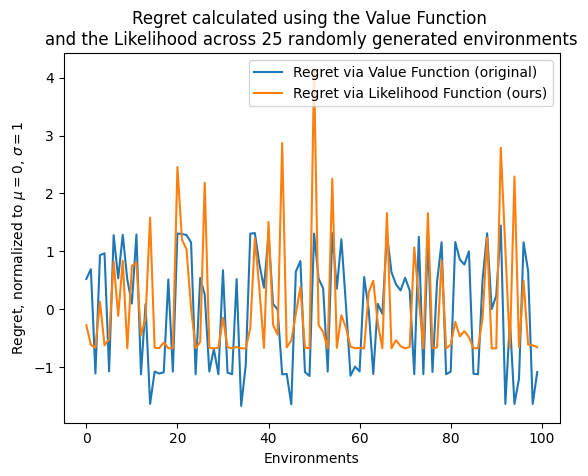

In [389]:
import matplotlib.pyplot as plt
plt.plot(regrets_value, label = "Regret via Value Function (original)")
plt.plot(regrets_likelihood, label = "Regret via Likelihood Function (ours)")
plt.legend()
plt.xlabel("Environments")
plt.ylabel("Regret, normalized to $\mu = 0$, $\sigma = 1$")
plt.title("Regret calculated using the Value Function \nand the Likelihood across 25 randomly generated environments")

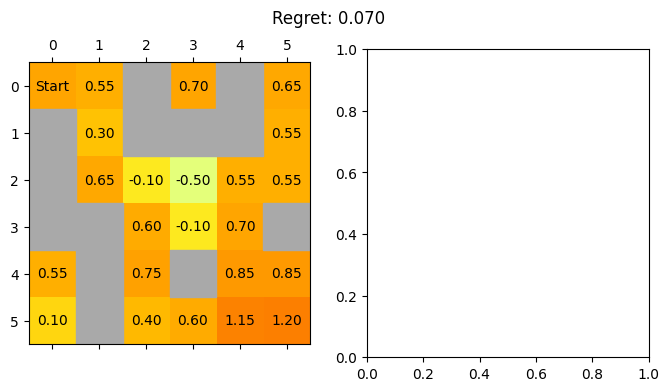

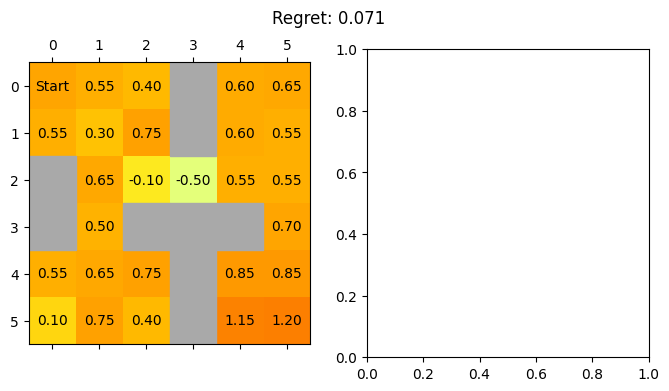

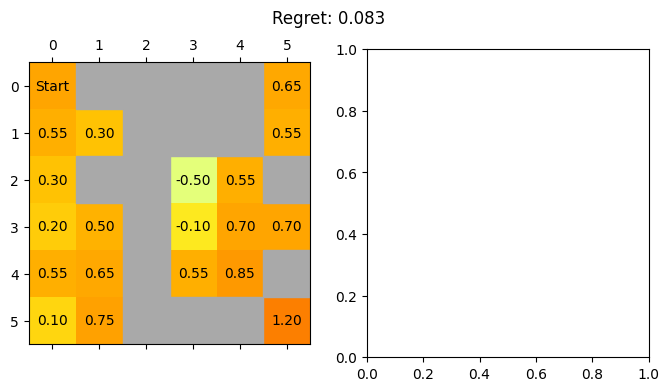

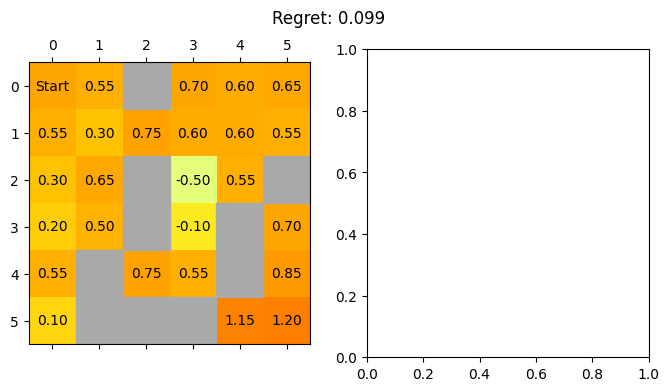

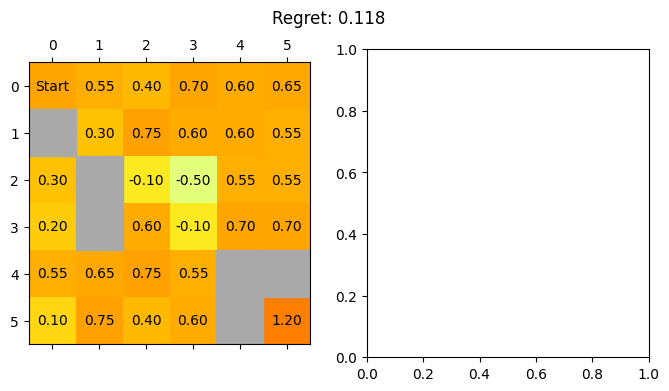

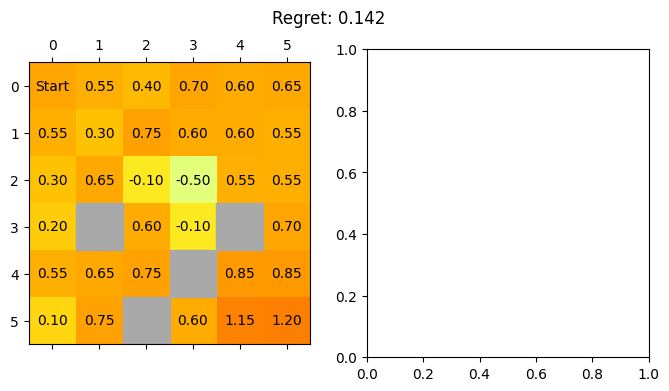

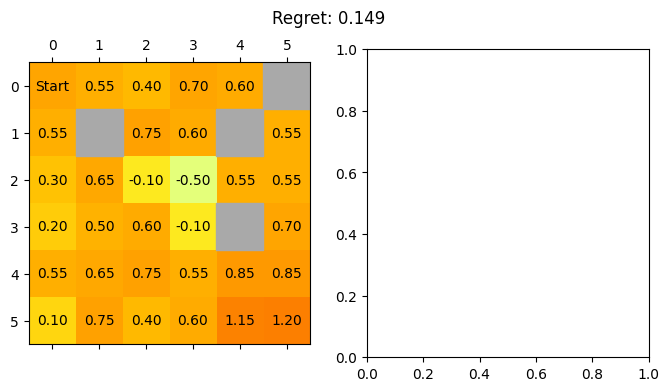

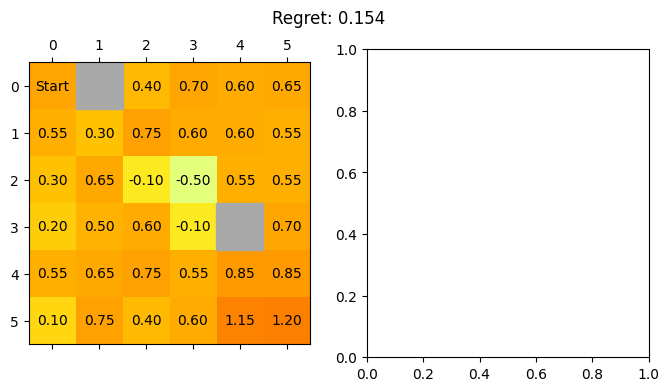

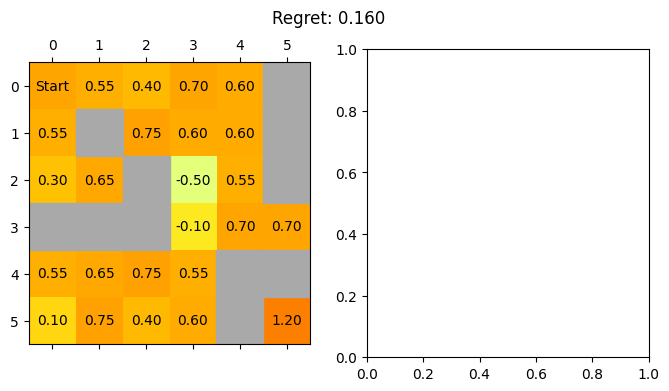

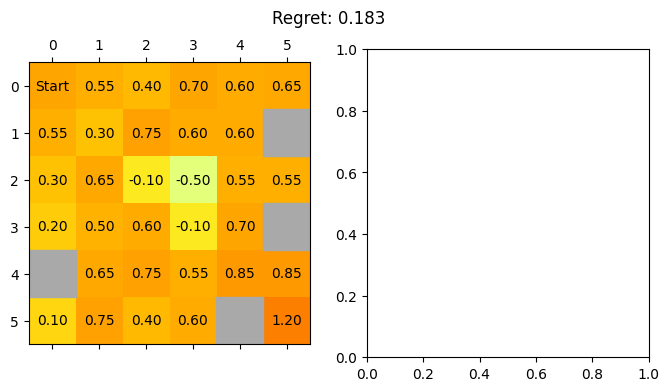

In [190]:
#add true reward to environments. we do this now to show that the true reward is never used in the code
plot_environments_with_regret(envs_value)

Plot Posterior Samples

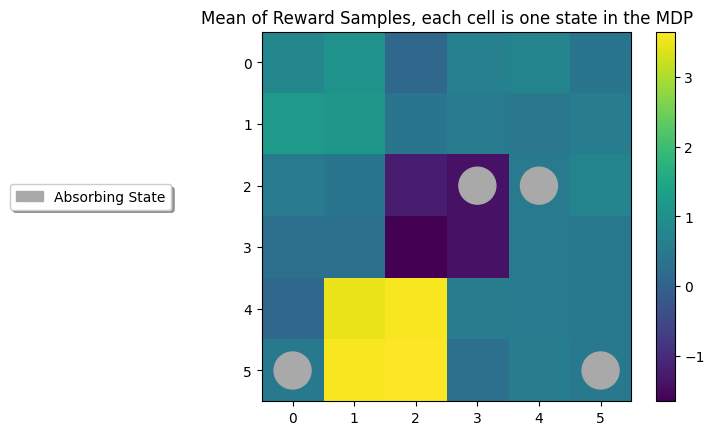

In [370]:
from matplotlib.patches import Circle

posterior_samples_reward_mean = np.zeros(shape = (n_states))

for sample in posterior_samples:
    posterior_samples_reward_mean += sample[2]

posterior_samples_reward_mean /= len(posterior_samples)

posterior_samples_reward_mean = posterior_samples_reward_mean.reshape(N,M)

fig, ax = plt.subplots()

plt.imshow(posterior_samples_reward_mean)
plt.colorbar()
plt.title("Mean of Reward Samples, each cell is one state in the MDP")

N_goal, M_goal = goal_states[0] // N, goal_states[0] % N 
ax.add_patch(Circle((M_goal, N_goal), 0.3, color="darkgray", label = "Absorbing State"))

for goal_state in goal_states[1:]:
    N_goal, M_goal = goal_state // N, goal_state % N 
    ax.add_patch(Circle((M_goal, N_goal), 0.3, color="darkgray"))

plt.legend(loc='lower left', bbox_to_anchor=(-0.7, 0.5), fancybox=True, shadow=True)

In [310]:
goal_states

array([15, 16, 30, 35])

Calculate Regret when learning only the reward function but using the value function instead of the likelihood (e.g. original Environment Design paper)

## Implementing the posterior sampling


In [92]:
p_limits = (0.5, 0.999)
gamma_limits = (0.5, 0.999)
R_limits = (0,1)


def prior_sample(n_states) -> ParamTuple:
    p = np.random.uniform(*p_limits)
    gamma = np.random.uniform(*gamma_limits)
    Rs = np.random.uniform(*R_limits, size=(n_states))

    return ParamTuple(p, gamma, Rs)


def parameter_proposal(previous_sample: ParamTuple, step_size: float, n_states: int) -> ParamTuple:
    p = np.random.normal(previous_sample.p, step_size)
    p = np.clip(p, *p_limits)

    gamma = np.random.normal(previous_sample.gamma, step_size)
    gamma = np.clip(gamma, *gamma_limits)

    reward_step = np.random.choice(
    [-step_size, 0, step_size], n_states, p=(0.15, 0.7, 0.15)
    )
    R = previous_sample.R + reward_step
    R = R.clip(min=0, max=1)

    return ParamTuple(p, gamma, R)


from scipy.stats import truncnorm


def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


def parameter_proposal_truncnorm(
    previous_sample: ParamTuple,
    step_size: float,
    n_states: int
) -> ParamTuple:
    # Truncated normal distribution for p
    p_dist = get_truncated_normal(
        mean=previous_sample.p, sd=step_size, low=p_limits[0], upp=p_limits[1]
    )
    p = p_dist.rvs()

    # Truncated normal distribution for gamma
    gamma_dist = get_truncated_normal(
        mean=previous_sample.gamma,
        sd=step_size,
        low=gamma_limits[0],
        upp=gamma_limits[1],
    )
    gamma = gamma_dist.rvs()

    R_dist = get_truncated_normal(
        mean=previous_sample.R, sd=step_size, low=R_limits[0], upp=R_limits[1]
    )
    R = R_dist.rvs(size = n_states)

    return ParamTuple(p, gamma, R)

In [80]:
def expert_trajectory_likelihood(
    parameter_sample: ParamTuple,
    expert_trajectories: list[tuple[Environment, list[StateTransition]]],
    goal_states: np.array
) -> float:
    log_likelihood = 0.0

    for env, trajectories in expert_trajectories:
        T_agent = transition_matrix(env.N, env.M, p=parameter_sample.p, goal_states = goal_states)
        policy = soft_q_iteration(
            parameter_sample.R, T_agent, gamma=parameter_sample.gamma, beta=20.0
        )
        for traj in trajectories:
            log_likelihood += compute_log_likelihood(env.T_true, policy, traj)

    return np.exp(log_likelihood)

In [81]:
from tqdm import trange

def bayesian_parameter_learning(
    # TODO: Find an appropriate data structure for expert trajectories
    # It needs to account for the possibility of multiple trajectories per environment
    expert_trajectories: list[tuple[Environment, list[StateTransition]]],
    sample_size: int,
    goal_states: np.array,
    n_states: int,
    previous_sample: ParamTuple = None,
):
    # Samples from the posterior
    posterior_samples: list[ParamTuple] = []
    n_accepted = 0
    step_size = 0.1

    # Start the chain at the previous sample if provided, otherwise sample from the prior
    if previous_sample is None:
        previous_sample = prior_sample(n_states)

    old_likelihood = expert_trajectory_likelihood(previous_sample, expert_trajectories, goal_states)

    it = trange(sample_size, desc="Posterior sampling", leave=False)
    for k in it:
        # Create a new proposal for (p_i, gamma_i)
        # proposed_parameter: ParamTuple = parameter_proposal(
        #     previous_sample, step_size=step_size
        # )
        proposed_parameter: ParamTuple = parameter_proposal_truncnorm(
            previous_sample, step_size=step_size, n_states = n_states
        )
        likelihood = expert_trajectory_likelihood(
            proposed_parameter, expert_trajectories, goal_states
        )

        # Check if we accept the proposal
        p = likelihood  # We don't multiply by the prior because it's uniform
        p_old = old_likelihood
        quotient = p / p_old
        if np.random.uniform(0, 1) < quotient:
            previous_sample = proposed_parameter
            old_likelihood = likelihood
            n_accepted += 1
        posterior_samples.append(previous_sample)

        # Based on current acceptance rates, adjust step size and n_steps
        acceptance_rate = n_accepted / (k + 1)
        if acceptance_rate > 0.25:
            step_size = round(min(1, step_size + 0.01), 3)
        elif acceptance_rate < 0.21:
            step_size = round(max(0.01, step_size - 0.01), 3)

        it.set_postfix(
            {
                "Acceptance rate": round(100 * acceptance_rate, 1),
                "step_size": step_size,
            }
        )

    return posterior_samples

In [90]:
def plot_posterior_distribution(
    posterior_samples: list[ParamTuple], true_params: ParamTuple = None, ax=None
):
    """
    Plot the join distribution of p and gamma from the posterior samples as a 2D histogram.
    Plot the mean of the reward distribution as a grid
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    # Unzipping the list of tuples
    p_values, gamma_values, R_values = zip(*(posterior_samples))

    # Plotting the 2D distribution
    ax.scatter(p_values, gamma_values, alpha=0.3)
    ax.set_title("Posterior distribution")
    ax.set_xlabel("$p_i$")
    ax.set_ylabel("$\\gamma_i$")
    ax.grid(True)
    ax.set_xlim(p_limits)
    ax.set_ylim(gamma_limits)

    if true_params is not None:
        ax.scatter(
            true_params.p,
            true_params.gamma,
            marker="*",
            color="red",
            label="True parameters",
        )
        ax.legend()

    posterior_samples_reward_mean = np.mean(R_values, axis = 0)
    posterior_samples_reward_mean = posterior_samples_reward_mean.reshape(N,M)

    fig, ax = plt.subplots()

    plt.imshow(posterior_samples_reward_mean, cmap=plt.cm.Wistia)
    plt.colorbar()
    plt.title("Mean of Reward Samples")

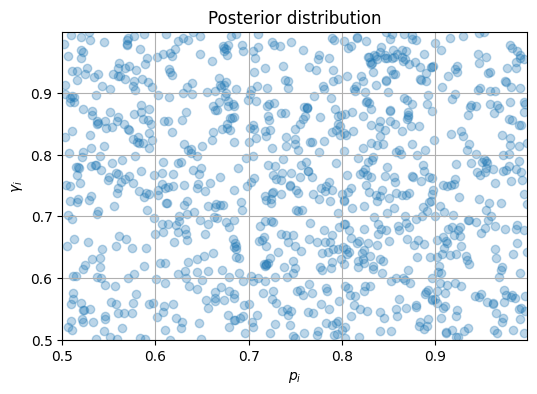

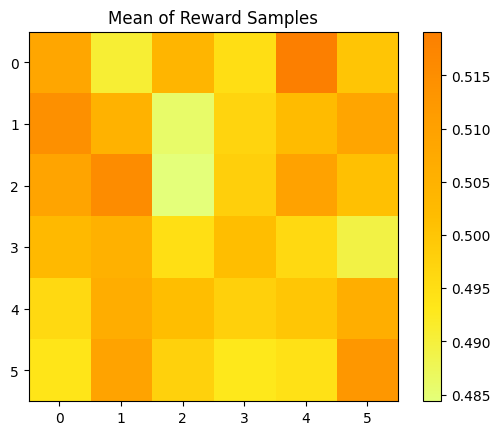

In [91]:
posterior_samples_0 = bayesian_parameter_learning([], 1_000, previous_sample=None, goal_states=goal_states, n_states=n_states)

plot_posterior_distribution(posterior_samples_0)

### Run a small end-to-end example


#### Start by finding an environment to generate initial trajectories from


In [97]:
#Set sample ranges for unknown parameters
p_limits = (0.9, 0.9)
gamma_limits = (0.8, 0.8)
R_limits = (0,1)

# 0. Setup
## 0.1 Setup the experiment
n_env_samples = 10
n_posterior_samples = 25
n_traj_per_sample = 10

## 0.2 Setup the environment
N, M = 6, 6
n_states, n_actions = N * M, 4

# Create a type of BigSmall world with a dangerous zone
R = np.zeros((N, M))
R[-1, 0] = 0.1
R[-1, -1] = 0.25
# R[2, -2] = -0.1
# R[2, -3] = -0.1
R = R.flatten()

goal_states = np.where(R != 0)[0]

del R

# Sample a subset of the posterior samples
sample_idxs = np.random.choice(
    np.arange(len(posterior_samples_0)), size=100, replace=False
)
samples = [posterior_samples_0[i] for i in sample_idxs]

candidate_envs_likelihood = get_candidate_environments(
    n_env_samples, N, M, T_true, goal_states, randomize_start_state=False
)

envs = environment_search(N, M, "likelihood", goal_states, n_env_samples, samples, n_traj_per_sample, candidate_envs_likelihood)

plot_environments_with_regret(envs)

Evaluating candidate environments using likelihood:   0%|          | 0/10 [00:00<?, ?it/s, highest_regret=-inf]

Evaluating candidate environments using likelihood:   0%|          | 0/10 [00:07<?, ?it/s, highest_regret=-inf]


KeyboardInterrupt: 

#### Create the unknown true agent and trajectories in the chosen environment


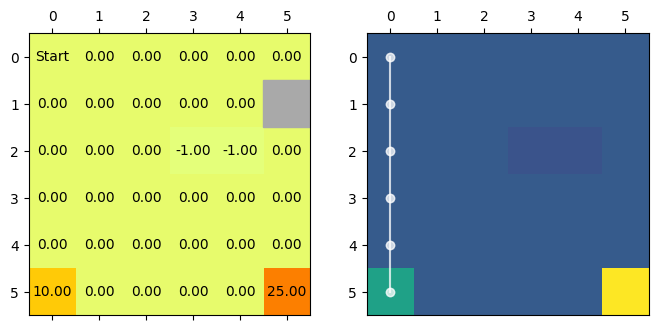

In [65]:
# Start by making the agent we want to learn the policy of
agent_p = 0.9
agent_gamma = 0.7
true_params = ParamTuple(agent_p, agent_gamma)

# Generate 2 trajectories in the env with the highest regret
env_1: Environment = envs[1]

T_agent = transition_matrix(env_1.N, env_1.M, p=agent_p, R=R)
agent_policy = soft_q_iteration(env_1.R, T_agent, gamma=agent_gamma, beta=20.0)

# Generate trajectories
absorbing_states = np.where(R != 0)[0]  # Absorbing states
trajectories = generate_n_trajectories(
    env_1.T_true,
    agent_policy,
    absorbing_states,
    n_trajectories=2,
    start_state=env_1.start_state,
    max_steps=(env_1.N + env_1.M - 2) * 2,
)

expert_trajectories = [(env_1, trajectories)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    R.reshape(N, M),
    env_1.wall_states,
    start_state=(env_1.start_state // M, env_1.start_state % M),
    ax=ax1,
)

# Show the trajectories
plot_trajectories(N, M, trajectories, R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

#### Sample from the posterior under these trajectories


In [68]:
# Sample from posterior
posterior_samples_1 = bayesian_parameter_learning(
    expert_trajectories, 1000, previous_sample=None
)

# Keep the last 10_000 of samples
posterior_samples_1 = posterior_samples_1[-10_000:]
# Plot the posterior distribution

Posterior sampling:   0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_104465/3353353860.py:35: RuntimeWarning: invalid value encountered in scalar divide
  quotient = p / p_old
Posterior sampling:   0%|          | 2/1000 [00:00<01:45,  9.48it/s, Acceptance rate=0, step_size=0.07]/tmp/ipykernel_104465/3353353860.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  quotient = p / p_old


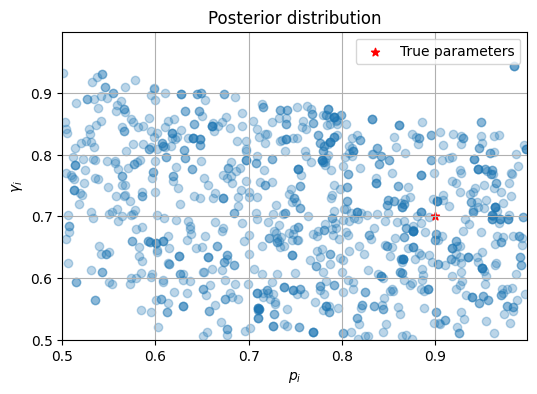

In [69]:
plot_posterior_distribution(
    posterior_samples_1, true_params=ParamTuple(agent_p, agent_gamma)
)

#### Start round two, maximize regret with the new posterior


In [84]:
# Sample a subset of the posterior samples
sample_idxs = np.random.choice(
    np.arange(len(posterior_samples_1)), size=100, replace=False
)
samples = [posterior_samples_1[i] for i in sample_idxs]

envs = environment_search(N, M, R, n_env_samples, samples, n_traj_per_sample)

Evaluating candidate environments: 100%|██████████| 10/10 [00:54<00:00,  5.44s/it, highest_regret=0.36]


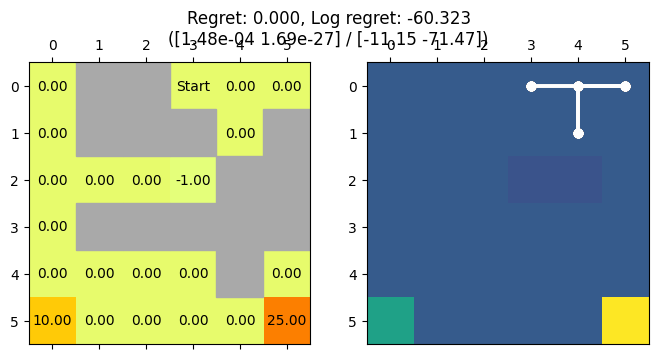

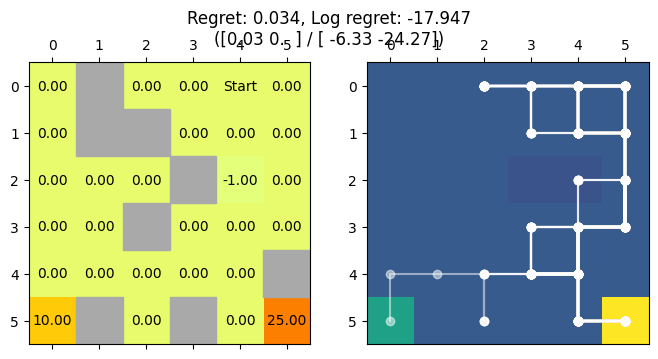

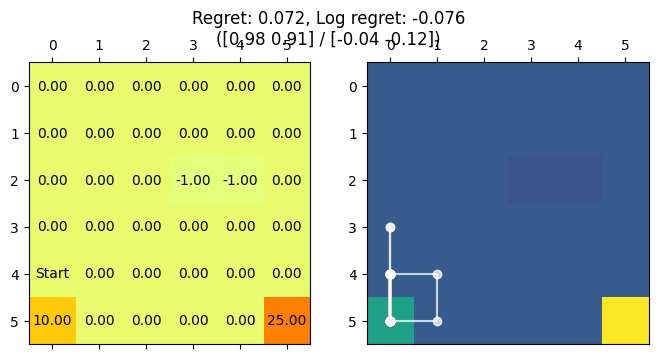

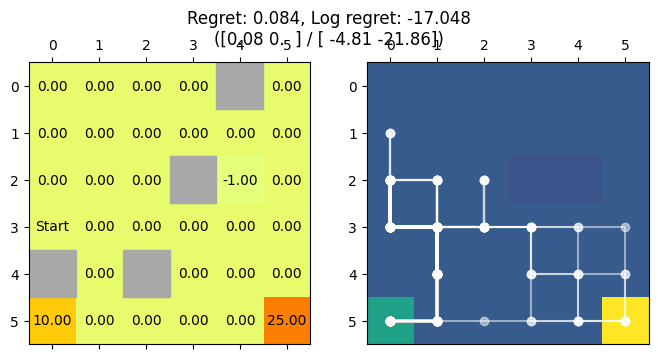

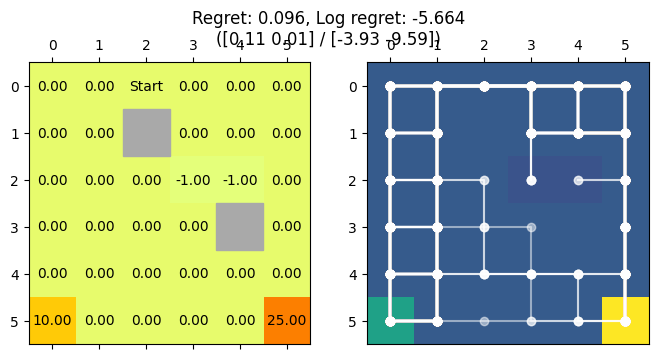

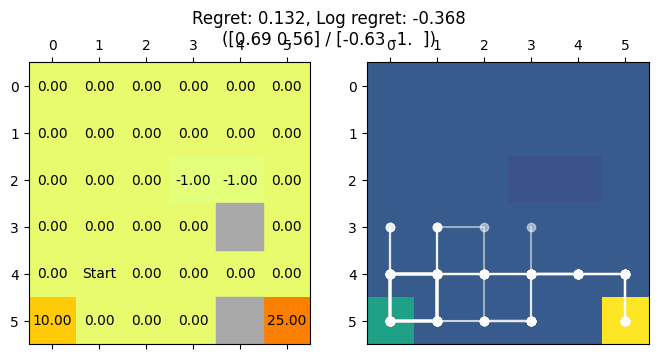

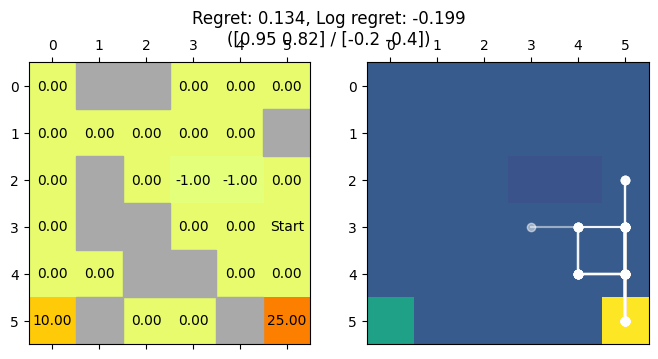

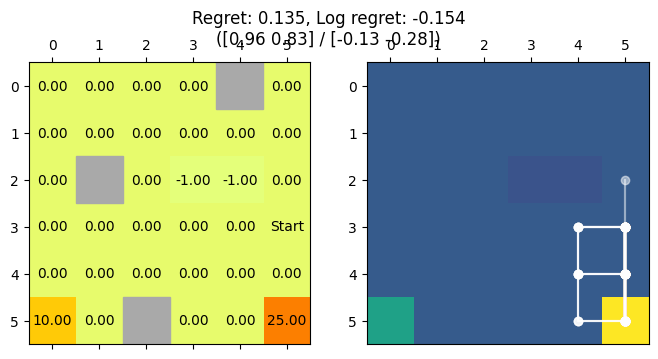

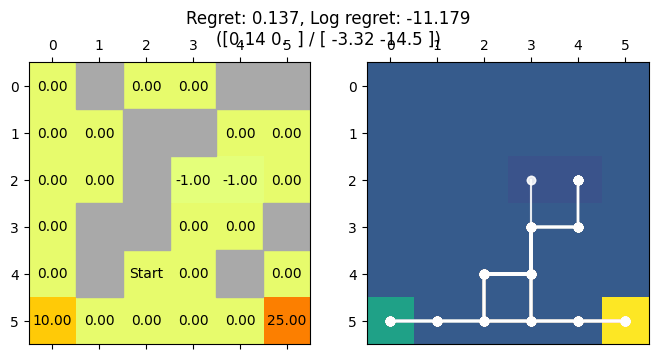

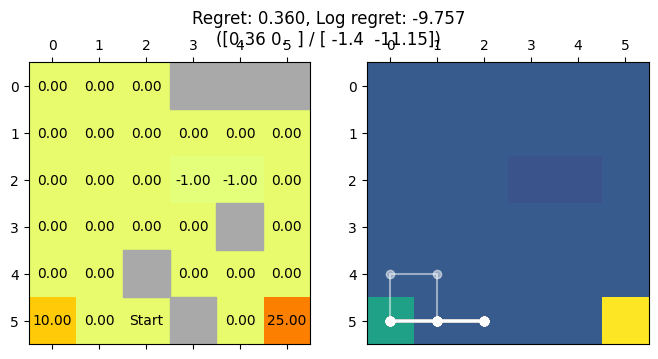

In [85]:
plot_environments_with_regret(envs)

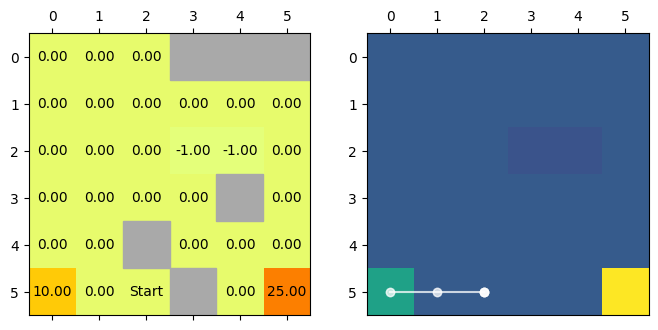

In [86]:
# Generate 2 trajectories in the env with the highest regret
env_2: Environment = envs[0]
N, M, R = env_2.N, env_2.M, env_2.R

T_agent = transition_matrix(N, M, p=agent_p, R=R)
agent_policy = soft_q_iteration(R, T_agent, gamma=agent_gamma, beta=20.0)

# Generate trajectories
absorbing_states = np.where(R != 0)[0]  # Absorbing states
trajectories_2 = generate_n_trajectories(
    env_2.T_true,
    agent_policy,
    absorbing_states,
    start_state=env_2.start_state,
    n_trajectories=2,
    max_steps=(env_2.N + env_2.M - 2) * 2,
)

# expert_trajectories.append((env_2, trajectories_2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plot_environment(
    R.reshape(N, M),
    env_2.wall_states,
    start_state=(env_2.start_state // M, env_2.start_state % M),
    ax=ax1,
)

# Show the trajectories_2
plot_trajectories(N, M, trajectories_2, R, ax=ax2)

# Remove the colorbar from the second plot
ax2.get_images()[0].colorbar.remove()

Posterior sampling:   0%|          | 0/1000 [00:00<?, ?it/s, Acceptance rate=100, step_size=0.12]

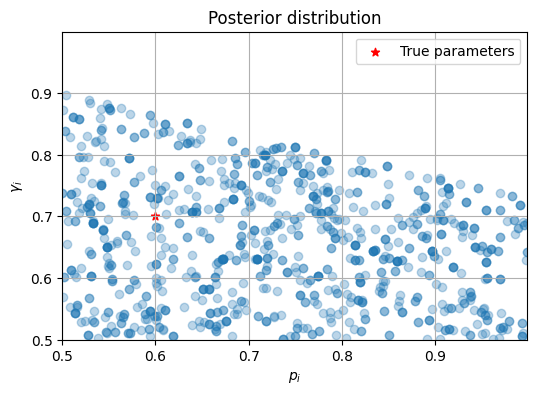

In [87]:
# Sample from posterior
posterior_samples_2 = bayesian_parameter_learning(
    expert_trajectories, 1_000, previous_sample=posterior_samples_1[-1]
)

# Plot the posterior distribution
plot_posterior_distribution(posterior_samples_2, true_params=true_params)

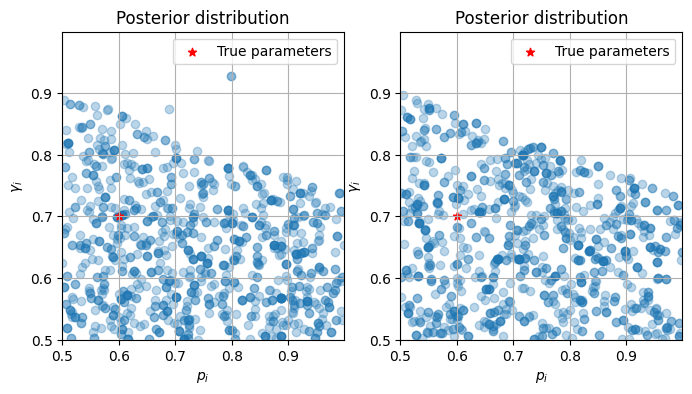

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

plot_posterior_distribution(posterior_samples_1, true_params=true_params, ax=ax1)
plot_posterior_distribution(posterior_samples_2, true_params=true_params, ax=ax2)

In [ ]:
# Calculate standard deviation of the posterior samples
p_values_1, gamma_values_1 = zip(*(posterior_samples_1))
p_values_2, gamma_values_2 = zip(*(posterior_samples_2))

print(f"p_1: {np.std(p_values_1):.3f}, gamma_1: {np.std(gamma_values_1):.3f}")
print(f"p_2: {np.std(p_values_2):.3f}, gamma_2: {np.std(gamma_values_2):.3f}")

p_1: 0.038, gamma_1: 0.028
p_2: 0.040, gamma_2: 0.027
